In [19]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [20]:
# Configure Kaggle API key
kaggle_username = "cptnmaaz37"
kaggle_key = "7dac7b7036e9f66256d70ea6cbf7ccf3"
kaggle_dir = os.path.join(os.path.expanduser("~"), ".kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")
with open(kaggle_json_path, "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)
os.chmod(kaggle_json_path, 0o600)
print("Kaggle API key configured successfully!")


Kaggle API key configured successfully!


In [21]:
# Download and unzip dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --unzip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:27<00:00, 190MB/s]
100% 2.29G/2.29G [00:27<00:00, 89.0MB/s]


In [22]:
# Define dataset directories
DATASET_DIR = "./chest_xray"
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VAL_DIR = os.path.join(DATASET_DIR, 'val')
TEST_DIR = os.path.join(DATASET_DIR, 'test')

Classes in training set: ['PNEUMONIA', 'NORMAL']
Classes in validation set: ['PNEUMONIA', 'NORMAL']
Classes in test set: ['PNEUMONIA', 'NORMAL']


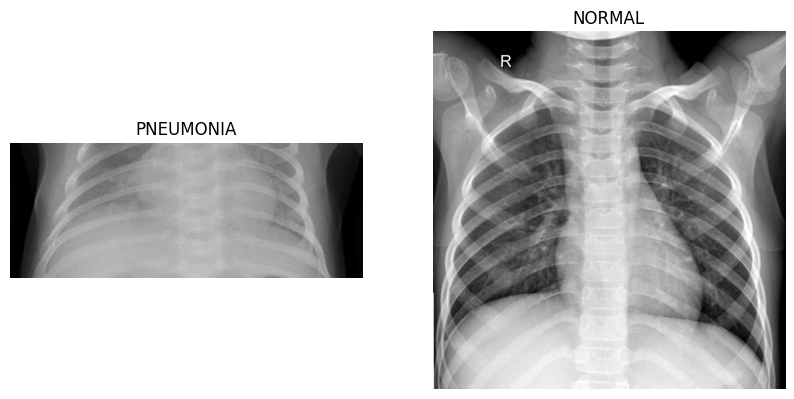

In [23]:
# Exploratory Data Analysis
print("Classes in training set:", os.listdir(TRAIN_DIR))
print("Classes in validation set:", os.listdir(VAL_DIR))
print("Classes in test set:", os.listdir(TEST_DIR))

# Visualizing sample images from each class
import glob
from PIL import Image

classes = os.listdir(TRAIN_DIR)
sample_images = {cls: glob.glob(os.path.join(TRAIN_DIR, cls, "*.jpeg"))[0] for cls in classes}

plt.figure(figsize=(10, 5))
for i, (cls, img_path) in enumerate(sample_images.items()):
    img = Image.open(img_path)
    plt.subplot(1, len(classes), i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(cls)
    plt.axis('off')
plt.show()


In [24]:
# Data Generators
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

data_gen = ImageDataGenerator(rescale=1.0 / 255.0)
data_gen_augmented = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = data_gen_augmented.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = data_gen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = data_gen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [25]:
# Build the Model
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
# Train the Model
EPOCHS = 10
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.6984 - loss: 0.6682 - val_accuracy: 0.8750 - val_loss: 0.3800
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.8853 - loss: 0.2577 - val_accuracy: 0.6875 - val_loss: 0.3954
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.9141 - loss: 0.2154 - val_accuracy: 0.8750 - val_loss: 0.3099
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.9215 - loss: 0.1923 - val_accuracy: 0.9375 - val_loss: 0.2950
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.9183 - loss: 0.1954 - val_accuracy: 0.9375 - val_loss: 0.3266
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.9192 - loss: 0.2004 - val_accuracy: 0.8750 - val_loss: 0.3253
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.9222 - loss: 0.1832 - val_accuracy: 0.8750 - val_loss: 0.3064
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9296 - loss: 0.1745 - val_accuracy: 0.937

In [27]:
# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8484 - loss: 0.3167
Test Loss: 0.24746058881282806
Test Accuracy: 0.8894230723381042


In [28]:
# Predictions and Metrics
predictions = model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int)
true_labels = test_generator.classes

roc_auc = roc_auc_score(true_labels, predictions)
print(f"ROC-AUC Score: {roc_auc}")

print(classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive']))

20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step
ROC-AUC Score: 0.9626342318650011
              precision    recall  f1-score   support

    Negative       0.91      0.79      0.84       234
    Positive       0.88      0.95      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



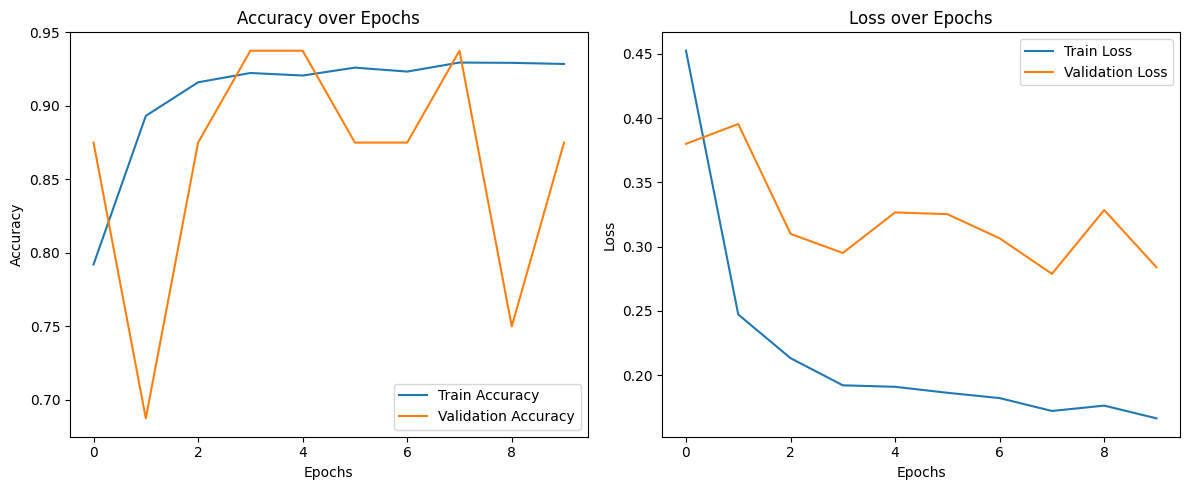

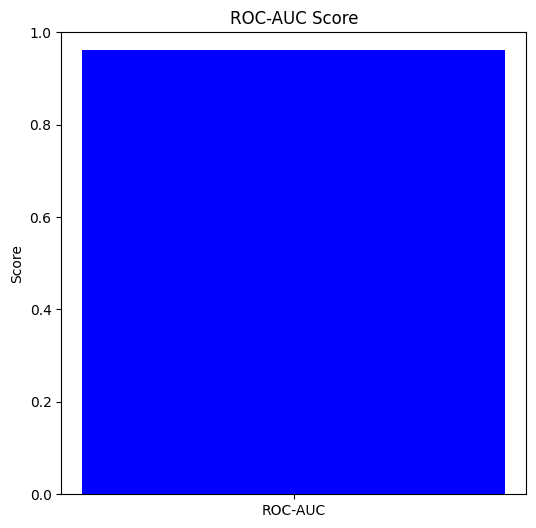

In [29]:
# Visualizations
# Plotting training accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot ROC-AUC
plt.figure(figsize=(6, 6))
plt.bar(['ROC-AUC'], [roc_auc], color='blue')
plt.title('ROC-AUC Score')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.show()


In [30]:
# Save Model and Reports
model.save("pneumonia_detection_model.h5")

with open("summary_report.txt", "w") as f:
    f.write(f"Test Accuracy: {test_accuracy}\n")
    f.write(f"ROC-AUC Score: {roc_auc}\n")
    f.write("Classification Report:\n")
    f.write(classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive']))

print("Model and reports saved successfully!")

Model and reports saved successfully!
